In [433]:
import os.path
from datetime import datetime as dt

import keras.utils.vis_utils
import keras_tuner as kt
import pandas as pd
import plotly.graph_objects as go
import tensorflow as tf
from IPython.core.display_functions import display
from dateutil.relativedelta import relativedelta
from keras import Sequential, layers, losses, metrics
from keras import callbacks
from keras.api.keras import optimizers

import file_helper

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
DATE_FORMAT = '%d.%m.%Y'

In [4]:
def convert_string_to_date(string_date: str) -> dt:
    return dt.strptime(string_date, DATE_FORMAT)

def normalize_columns_in_dataframe(data: pd.DataFrame, columns: list[str] = None) -> None:
    data_columns = data[columns]
    min_values = data_columns.min()
    max_values = data_columns.max()
    data[columns] = (data_columns - min_values) / (max_values - min_values)

In [5]:
geochem_data = pd.read_excel(file_helper.get_geo_chem_file_path(), 'dubki_h_tau')

In [6]:
events_catalog_data = pd.read_csv(file_helper.get_events_catalog_file_path(), sep=';').iloc[10000:]
events_catalog_data['Date'] = pd.to_datetime(events_catalog_data['Date'], format=DATE_FORMAT)

In [452]:
DATE_TARGET_OFFSET = relativedelta(months=1)
DATE_TARGET_DURATION = relativedelta(months=1)
STARTING_EVENT_CLASS = 12

In [453]:
preprocessed_data = pd.DataFrame(geochem_data)

normalize_columns_in_dataframe(preprocessed_data, ['events', 'ascend', 'maximum', 'descend', 'minimum'])

breakpoint_date = convert_string_to_date('31.12.2021') - DATE_TARGET_OFFSET - DATE_TARGET_DURATION
reserved_data = preprocessed_data[breakpoint_date < preprocessed_data['to date']].drop(['from date'], axis=1)
preprocessed_data = preprocessed_data[preprocessed_data['to date'] <= breakpoint_date]
preprocessed_data['target'] = preprocessed_data['to date'].map(lambda date: 1 if len(events_catalog_data[
    ((date + DATE_TARGET_OFFSET) <= events_catalog_data['Date'])
    & (events_catalog_data['Date'] <= (date + DATE_TARGET_OFFSET + DATE_TARGET_DURATION))
    & (STARTING_EVENT_CLASS <= events_catalog_data['Class'])
]) > 0 else 0)
preprocessed_data = preprocessed_data.drop(['from date', 'to date'], axis=1)

In [454]:
display(
    preprocessed_data.tail(),
    reserved_data.head()
)

,events,ascend,maximum,descend,minimum,target
5666,0.947368,0.527596,0.478661,0.551603,0.115323,0
5667,0.947368,0.527596,0.472201,0.551603,0.119320,0
5668,0.954887,0.523359,0.474255,0.547756,0.120804,0
5669,0.954887,0.584622,0.413340,0.532622,0.158652,0
5670,0.954887,0.584622,0.407500,0.532622,0.162869,0


,to date,events,ascend,maximum,descend,minimum
5671,2021-10-31,0.962406,0.580060,0.410353,0.528869,0.164298
5672,2021-11-01,0.969925,0.575498,0.413162,0.525116,0.165798
5673,2021-11-02,0.969925,0.587458,0.413162,0.525116,0.161475
5674,2021-11-03,0.962406,0.592098,0.411590,0.528869,0.156026
5675,2021-11-04,0.954887,0.596737,0.418126,0.536675,0.146182


In [455]:
x = preprocessed_data.drop(['target'], axis=1)
y = preprocessed_data['target']

In [456]:
RANDOM_STATE = 42
TRAIN_FRAC = .8

In [457]:
x_train, y_train = x.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE), y.sample(frac=TRAIN_FRAC, random_state=RANDOM_STATE)
x_test, y_test = x.drop(x_train.index), y.drop(y_train.index)

In [458]:
def model_builder(hp: kt.HyperParameters):
    hp_activation = hp.Choice('activation', values=['linear', 'relu', 'tanh', 'sigmoid'])
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    hp_activation_1 = hp.Choice('activation_1', values=['linear', 'relu', 'tanh', 'sigmoid'])
    hp_units_1 = hp.Int('units_1', min_value=8, max_value=128, step=8)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model = Sequential([
        layers.InputLayer((5,)),
        layers.Dense(units=hp_units, activation=hp_activation),
        layers.Dense(units=hp_units_1, activation=hp_activation_1),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp_learning_rate),
        loss=losses.BinaryCrossentropy(from_logits=True),
        metrics=[metrics.BinaryAccuracy(name='accuracy')]
    )

    return model

In [459]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=200,
    factor=3,
    directory=os.path.join(file_helper.get_root_path(), 'data/hypermodel'),
    project_name='geo_analysis'
)

In [460]:
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [461]:
tuner.search(x_train, y_train, epochs=100, validation_split=.2, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 254 Complete [00h 01m 15s]
val_accuracy: 0.8733479976654053

Best val_accuracy So Far: 0.8733479976654053
Total elapsed time: 01h 09m 23s
INFO:tensorflow:Oracle triggered exit


In [462]:
print(*[f'{k:20}: {v}' for k, v in best_hps.values.items()], sep='\n')

activation          : tanh
units               : 40
activation_1        : tanh
units_1             : 56
learning_rate       : 0.01
tuner/epochs        : 200
tuner/initial_epoch : 0
tuner/bracket       : 0
tuner/round         : 0


In [463]:
# model = Sequential([
#     layers.Dense(64, name='dense_0'),
#     layers.Dense(32, activation=activations.tanh, name='dense_1'),
#     layers.Dense(16, activation=activations.tanh, name='dense_2'),
#     layers.Dense(1, name='output')
# ])
# model.compile(
#     optimizer=optimizers.Adam(name='adam'),
#     loss=losses.BinaryCrossentropy(name='binary_crossentropy', from_logits=True),
#     metrics=[metrics.BinaryAccuracy(name='accuracy')]
# )

model = tuner.hypermodel.build(best_hps)

In [464]:
history = model.fit(
    x_train, y_train,
    epochs=best_hps.get('tuner/epochs'),
    validation_split=.2,
    verbose=0
)

In [465]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 40)                240       
                                                                 
 dense_4 (Dense)             (None, 56)                2296      
                                                                 
 dense_5 (Dense)             (None, 1)                 57        
                                                                 
Total params: 2,593
Trainable params: 2,593
Non-trainable params: 0
_________________________________________________________________


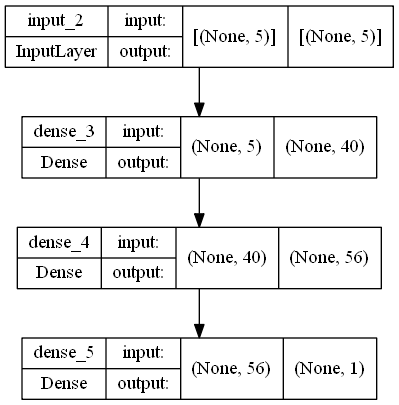

In [466]:
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [467]:
model.predict(x_test)

array([[-0.03796744],
       [-0.03796744],
       [ 0.71917605],
       ...,
       [-1.8256643 ],
       [-2.2206137 ],
       [-2.1188521 ]], dtype=float32)

In [468]:
model.evaluate(x_test, y_test)

36/36 [==============================] - 1s 14ms/step - loss: 0.1931 - accuracy: 0.9118


[0.19309741258621216, 0.9118165969848633]

In [469]:
history.history['val_accuracy'][-5:]

[0.9052863717079163,
 0.8975771069526672,
 0.9129955768585205,
 0.9096916317939758,
 0.8964757919311523]

In [470]:
reserved_data.head()

,to date,events,ascend,maximum,descend,minimum
5671,2021-10-31,0.962406,0.580060,0.410353,0.528869,0.164298
5672,2021-11-01,0.969925,0.575498,0.413162,0.525116,0.165798
5673,2021-11-02,0.969925,0.587458,0.413162,0.525116,0.161475
5674,2021-11-03,0.962406,0.592098,0.411590,0.528869,0.156026
5675,2021-11-04,0.954887,0.596737,0.418126,0.536675,0.146182


In [471]:
condition = (convert_string_to_date('1.1.2021') <= reserved_data['to date'])

X_pred = reserved_data[condition].drop(['to date'], axis=1)

# X_pred = processed_data[condition]

result_pred = model.predict(X_pred)
result_proba = tf.nn.sigmoid(result_pred).numpy()

In [472]:
reserved_data[condition]

,to date,events,ascend,maximum,descend,minimum
5671,2021-10-31,0.962406,0.580060,0.410353,0.528869,0.164298
5672,2021-11-01,0.969925,0.575498,0.413162,0.525116,0.165798
5673,2021-11-02,0.969925,0.587458,0.413162,0.525116,0.161475
5674,2021-11-03,0.962406,0.592098,0.411590,0.528869,0.156026
5675,2021-11-04,0.954887,0.596737,0.418126,0.536675,0.146182
...,...,...,...,...,...,...
5728,2021-12-27,0.864662,0.582101,0.388848,0.506212,0.206975
5729,2021-12-28,0.864662,0.556172,0.410158,0.499603,0.201885
5730,2021-12-29,0.872180,0.551629,0.418601,0.495768,0.198613
5731,2021-12-30,0.879699,0.547086,0.427045,0.505377,0.185414


In [473]:
figure_x = reserved_data[condition]['to date']
figure_x_text = figure_x.map(lambda e: f'[{(e + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(e + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]')
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=figure_x,
    y=1-result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    groupnorm='percent',
    name='No event',
    text=figure_x_text
))
fig.add_trace(go.Scatter(
    x=figure_x,
    y=result_proba[:,0],
    mode='lines',
    stackgroup='one',
    line=dict(width=.25),
    name='Event predicted',
    text=figure_x_text
))
fig.update_layout(
    title='Probability of event',
    # width=500, height=500
)
fig.show()

In [474]:
result = pd.DataFrame(reserved_data[condition])

In [475]:
result['predicted'] = result_pred
result[(result['predicted'] > 0)]['to date'].map(
    lambda date:
    f'K >= {STARTING_EVENT_CLASS}; Dates [{(date + DATE_TARGET_OFFSET).strftime("%d.%m.%Y")}..{(date + DATE_TARGET_OFFSET + DATE_TARGET_DURATION).strftime("%d.%m.%Y")}]'
)

Series([], Name: to date, dtype: object)